# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

Make accurate salary preditctions for new job postings that are based on known salaries so the company is able to recruit and retain top talent while controlling payroll expenses.

In [1]:
# Import libraries
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
%matplotlib inline

# My info 
__author__ = "Dominick DiTucci"
__email__ = "djditucci@gmail.com "

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [2]:
# Load the data into a Pandas dataframe

test_features = '/Users/DJ/Salary-Prediction-Portfolio/data/test_features.csv'
train_features = '/Users/DJ/Salary-Prediction-Portfolio/data/train_features.csv'
train_salaries = '/Users/DJ/Salary-Prediction-Portfolio/data/train_salaries.csv'

test_featuresDF = pd.read_csv(test_features)
train_featuresDF = pd.read_csv(train_features)
train_salariesDF = pd.read_csv(train_salaries)

In [3]:
# View all columns headers
print(test_featuresDF.columns)
print(train_featuresDF.columns)
print(train_salariesDF.columns)

Index(['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry',
       'yearsExperience', 'milesFromMetropolis'],
      dtype='object')
Index(['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry',
       'yearsExperience', 'milesFromMetropolis'],
      dtype='object')
Index(['jobId', 'salary'], dtype='object')


### ---- 3 Clean the data ----

In [4]:
# Look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it

# Check for missing data in test_featuresDF

missing_test_featuresDF = test_featuresDF.isnull()

for column in missing_test_featuresDF.columns.values.tolist():
    print(column)
    print(missing_test_featuresDF[column].value_counts())
    print("")

jobId
False    1000000
Name: jobId, dtype: int64

companyId
False    1000000
Name: companyId, dtype: int64

jobType
False    1000000
Name: jobType, dtype: int64

degree
False    1000000
Name: degree, dtype: int64

major
False    1000000
Name: major, dtype: int64

industry
False    1000000
Name: industry, dtype: int64

yearsExperience
False    1000000
Name: yearsExperience, dtype: int64

milesFromMetropolis
False    1000000
Name: milesFromMetropolis, dtype: int64



In [5]:
# Check top 5 rows of test_featuresDF
print("The first 5 rows of test_featuresDF:")
test_featuresDF.head()

The first 5 rows of test_featuresDF:


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


In [6]:
# Check shape of test_featuresDF
print('The shape of test_featuresDF is: ', test_featuresDF.shape)

The shape of test_featuresDF is:  (1000000, 8)


In [7]:
# Check for missing data in train_featuresDF

missing_train_featuresDF = train_featuresDF.isnull()

for column in missing_train_featuresDF.columns.values.tolist():
    print(column)
    print(missing_train_featuresDF[column].value_counts())
    print("")

jobId
False    1000000
Name: jobId, dtype: int64

companyId
False    1000000
Name: companyId, dtype: int64

jobType
False    1000000
Name: jobType, dtype: int64

degree
False    1000000
Name: degree, dtype: int64

major
False    1000000
Name: major, dtype: int64

industry
False    1000000
Name: industry, dtype: int64

yearsExperience
False    1000000
Name: yearsExperience, dtype: int64

milesFromMetropolis
False    1000000
Name: milesFromMetropolis, dtype: int64



In [8]:
# Check top 5 rows of train_featuresDF
print("The first 5 rows of train_featuresDF:")
train_featuresDF.head()


The first 5 rows of train_featuresDF:


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [9]:
# Check shape of train_featuresDF
print('The shape of train_featuresDF is: ', train_featuresDF.shape)

The shape of train_featuresDF is:  (1000000, 8)


In [10]:
# Check for missing data in train_salariesDF

missing_train_salariesDF = train_salariesDF.isnull()

for column in missing_train_salariesDF.columns.values.tolist():
    print(column)
    print(missing_train_salariesDF[column].value_counts())
    print("")

jobId
False    1000000
Name: jobId, dtype: int64

salary
False    1000000
Name: salary, dtype: int64



In [11]:
# Check shape of train_salariesDF before deleting values
print('The shape of train_salariesDF is:', train_salariesDF.shape)

The shape of train_salariesDF is: (1000000, 2)


In [12]:
# Check top 5 rows of train_salariesDF
print("The first 5 rows of train_salariesDF:")
train_salariesDF.head()

The first 5 rows of train_salariesDF:


,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [13]:
# train_salariesDF and train__featuresDF have overlapping data, so they can be merged

train_data_merged = pd.merge(train_salariesDF, train_featuresDF, on = 'jobId')

# Check shape of merged data
print("The shape of train_data_merged is:",  train_data_merged.shape)

The shape of train_data_merged is: (1000000, 9)


In [14]:
# Check for invalid salaries, show with jobid

zero_salary = train_salariesDF['salary']<=0
invalid_salary = train_salariesDF[zero_salary]

invalid_salary

# There are 5 invalid salaries

,jobId,salary
30559,JOB1362684438246,0
495984,JOB1362684903671,0
652076,JOB1362685059763,0
816129,JOB1362685223816,0
828156,JOB1362685235843,0


In [15]:
# Remove invalid salaries since there are only 5/1,000,000

train_data_merged = train_data_merged.drop(invalid_salary.index.tolist())

print(train_data_merged)

                   jobId  salary companyId         jobType       degree  \
0       JOB1362684407687     130    COMP37             CFO      MASTERS   
1       JOB1362684407688     101    COMP19             CEO  HIGH_SCHOOL   
2       JOB1362684407689     137    COMP52  VICE_PRESIDENT     DOCTORAL   
3       JOB1362684407690     142    COMP38         MANAGER     DOCTORAL   
4       JOB1362684407691     163     COMP7  VICE_PRESIDENT    BACHELORS   
5       JOB1362684407692     113    COMP15         MANAGER     DOCTORAL   
6       JOB1362684407693     178    COMP15             CFO         NONE   
7       JOB1362684407694      73    COMP24          JUNIOR    BACHELORS   
8       JOB1362684407695      31    COMP20         JANITOR  HIGH_SCHOOL   
9       JOB1362684407696     104    COMP41  VICE_PRESIDENT    BACHELORS   
10      JOB1362684407697     102    COMP56         JANITOR  HIGH_SCHOOL   
11      JOB1362684407698     144     COMP7             CEO      MASTERS   
12      JOB1362684407699 

In [18]:
# Reset index after dropping 5 rows
train_data_merged.reset_index(drop=True, inplace=True)

# Check last 5 rows
train_data_merged.tail()

,jobId,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
999990,JOB1362685407682,88,COMP56,VICE_PRESIDENT,BACHELORS,CHEMISTRY,HEALTH,19,94
999991,JOB1362685407683,160,COMP24,CTO,HIGH_SCHOOL,NONE,FINANCE,12,35
999992,JOB1362685407684,64,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81
999993,JOB1362685407685,149,COMP3,CFO,MASTERS,NONE,HEALTH,6,5
999994,JOB1362685407686,88,COMP59,JUNIOR,BACHELORS,NONE,EDUCATION,20,11


In [19]:
# Check data types
train_data_merged.dtypes

# Some object variables may need to be converted to dummy variables

jobId                  object
salary                  int64
companyId              object
jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
dtype: object

### ---- 4 Explore the data (EDA) ----

In [19]:
# summarize each feature variable
# summarize the target variable
# look for correlation between each feature and the target
# look for correlation between features

In [20]:
# See how many unique values for each category
train_data_merged.nunique()

# CompanyId and jobID have a lot of unique values and may not be needed as dummy variables.
# jobType, degree, major, and industry have <10 unique values and would probably be relevant to make dummy variables.

jobId                  999995
salary                    279
companyId                  63
jobType                     8
degree                      5
major                       9
industry                    7
yearsExperience            25
milesFromMetropolis       100
dtype: int64

In [21]:
# Summary statistics for int/floats
train_data_merged.describe()

,salary,yearsExperience,milesFromMetropolis
count,999995.000000,999995.000000,999995.000000
mean,116.062398,11.992407,49.529381
std,38.717163,7.212390,28.877721
min,17.000000,0.000000,0.000000
25%,88.000000,6.000000,25.000000
50%,114.000000,12.000000,50.000000
75%,141.000000,18.000000,75.000000
max,301.000000,24.000000,99.000000


In [22]:
# Summary for categorical data
train_data_merged.describe(include=object)

,jobId,companyId,jobType,degree,major,industry
count,999995,999995,999995,999995,999995,999995
unique,999995,63,8,5,9,7
top,JOB1362685093532,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236975,532353,143205


/Users/DJ/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


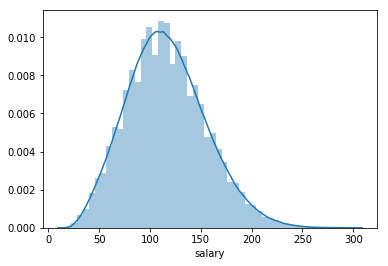

In [23]:
# View distribution of salaries
sns.distplot(train_data_merged['salary'])


In [24]:
# Distribution appears normal, check skewness and kurtosis
print("Salary skewness:", train_data_merged['salary'].skew())
print("Salary kurtosis:", train_data_merged['salary'].skew())

if train_data_merged['salary'].skew() <= 0.5:
    print("Salary distribution is approximately symmetric")
elif train_data_merged['salary'].skew() > 0.5:
        print("Salary distribution is skewed")

Salary skewness: 0.34652727907668734
Salary kurtosis: 0.34652727907668734
Salary distribution is approximately symmetric


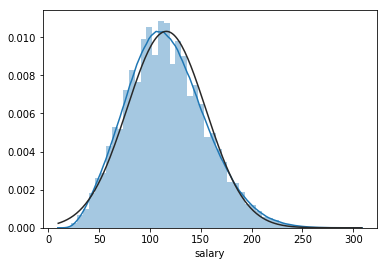

In [25]:
# Visually verify normal distribution
sns.distplot(train_data_merged['salary'], fit=norm)

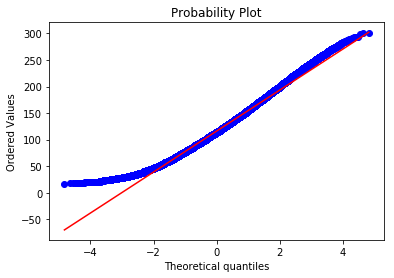

In [26]:
res = stats.probplot(train_data_merged['salary'], plot=plt)

In [27]:
# Check correlation between salary, experience, and distance from metropolis
train_data_merged.corr()

# weak correlation...?

,salary,yearsExperience,milesFromMetropolis
salary,1.000000,0.375013,-0.297686
yearsExperience,0.375013,1.000000,0.000672
milesFromMetropolis,-0.297686,0.000672,1.000000


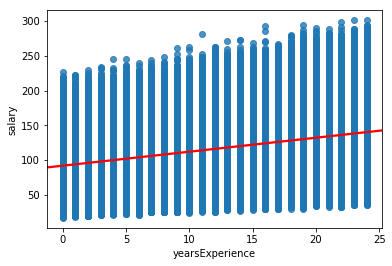

In [28]:
# Years experience as potential predictor of salary
sns.regplot(x = 'yearsExperience', y = 'salary', data = train_data_merged, line_kws = {'color': 'red'})
sns.set_context('notebook')
#moderate positive correlation

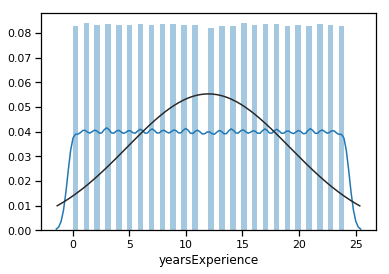

In [29]:
# Check for normal distribution of years experience
sns.distplot(train_data_merged['yearsExperience'], fit=norm)

# Years of experience distribution is relatively uniform

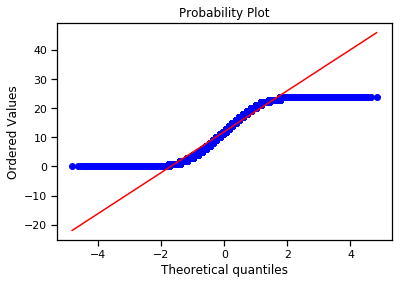

In [30]:
res = stats.probplot(train_data_merged['yearsExperience'], plot=plt)

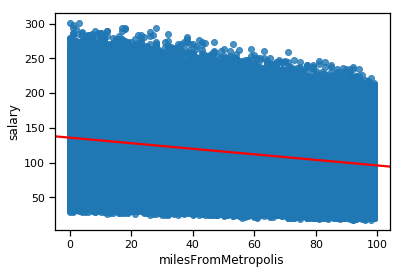

In [31]:
# Miles from metropolis as potential predictor of salary
sns.regplot(x = 'milesFromMetropolis', y = 'salary', data = train_data_merged, line_kws = {'color': 'red'})
# weak negative correlation

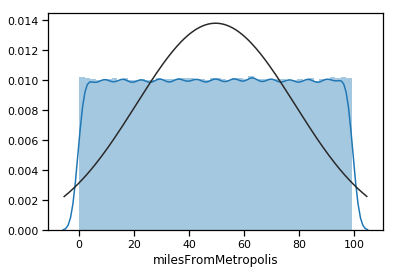

In [32]:
# Check for normal distribution of mile from metropolis
sns.distplot(train_data_merged['milesFromMetropolis'], fit=norm)

# Miles from metropolis distribution is relatively uniform

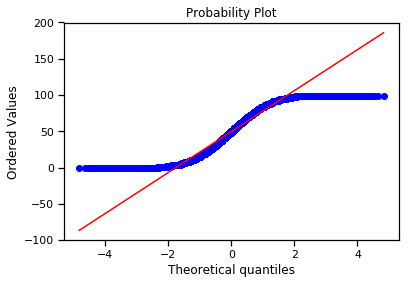

In [33]:
res = stats.probplot(train_data_merged['milesFromMetropolis'], plot=plt)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]),
 <a list of 63 Text xticklabel objects>)

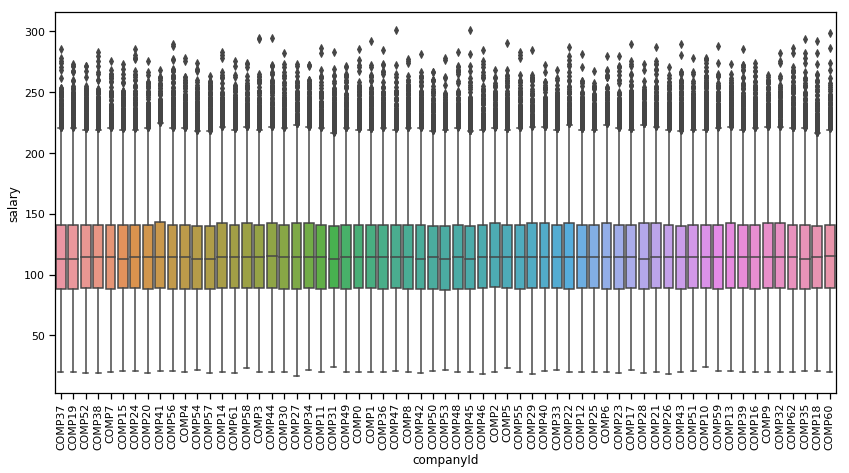

In [35]:
# View relationship between salary and company ID
var = 'companyId'
data = pd.concat([train_data_merged['salary'], train_data_merged[var]], axis = 1)
f, ax = plt.subplots(figsize=(14, 7))
fig = sns.boxplot(x=var, y='salary', data=data)
plt.xticks(rotation=90)


In [36]:
# Value counts for each company and convert to dataframe

companyId_counts =  train_data_merged['companyId'].value_counts().to_frame()
print(companyId_counts)

# Each company is approximately the same size

# Rename column and index in companyId_counts
companyId_counts.rename(columns={'companyId': 'value_counts'}, inplace=True)
companyId_counts.index.name = 'companyId'
companyId_counts

        companyId
COMP39      16193
COMP35      16114
COMP59      16066
COMP30      16041
COMP3       16028
COMP40      16007
COMP51      16005
COMP44      16004
COMP9       15988
COMP56      15979
COMP54      15977
COMP46      15967
COMP58      15961
COMP19      15958
COMP32      15958
COMP18      15957
COMP13      15956
COMP43      15955
COMP21      15949
COMP62      15943
COMP42      15943
COMP25      15931
COMP48      15930
COMP4       15918
COMP23      15918
COMP20      15910
COMP10      15909
COMP14      15908
COMP22      15907
COMP37      15905
...           ...
COMP41      15859
COMP45      15850
COMP6       15837
COMP24      15831
COMP61      15822
COMP1       15820
COMP38      15819
COMP34      15809
COMP33      15801
COMP60      15799
COMP5       15798
COMP47      15796
COMP28      15794
COMP50      15791
COMP12      15783
COMP16      15783
COMP49      15779
COMP53      15776
COMP27      15773
COMP7       15767
COMP55      15767
COMP31      15756
COMP29      15754
COMP26    

,value_counts
companyId,
COMP39,16193
COMP35,16114
COMP59,16066
COMP30,16041
COMP3,16028
COMP40,16007
COMP51,16005
COMP44,16004
COMP9,15988


In [37]:
# Group companyId_counts, find mean salary of each company
companyIdGrouped = train_data_merged[['companyId', 'salary']]
companyIdGrouped = companyIdGrouped.groupby(['companyId'], as_index=False).mean()
companyIdGrouped

,companyId,salary
0,COMP0,115.963615
1,COMP1,116.048609
2,COMP10,116.019800
3,COMP11,116.113029
4,COMP12,116.086485
5,COMP13,116.561795
6,COMP14,116.303495
7,COMP15,115.847117
8,COMP16,116.358424
9,COMP17,116.315940


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

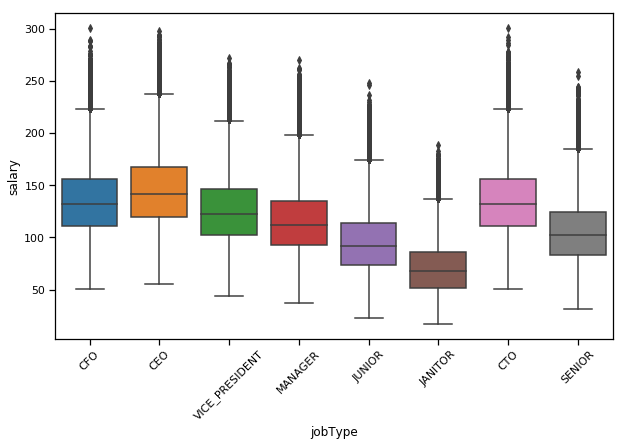

In [38]:
# View relationship between salary and job type
var = 'jobType'
data = pd.concat([train_data_merged['salary'], train_data_merged[var]], axis=1)
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.boxplot(x=var, y='salary', data=data)
plt.xticks(rotation=45)

# Janitor has lowest salary range. CEO and CTO have the highest followed by CFO.

In [39]:
# Value counts for each jobType and convert to dataframe

jobType_counts =  train_data_merged['jobType'].value_counts().to_frame()
print(jobType_counts)

# Each jobType has similar number of employees

# Rename column and index in jobType_counts
jobType_counts.rename(columns={'jobType': 'value_counts'}, inplace=True)
jobType_counts.index.name = 'jobType'
jobType_counts


                jobType
SENIOR           125886
VICE_PRESIDENT   125234
MANAGER          125120
CTO              125045
JANITOR          124971
CEO              124778
JUNIOR           124592
CFO              124369


,value_counts
jobType,
SENIOR,125886
VICE_PRESIDENT,125234
MANAGER,125120
CTO,125045
JANITOR,124971
CEO,124778
JUNIOR,124592
CFO,124369


In [40]:
# Group jobType_counts, find mean salary of each jobType
jobTypeGrouped = train_data_merged[['jobType', 'salary']]
jobTypeGrouped = jobTypeGrouped.groupby(['jobType'], as_index=False).mean()
jobTypeGrouped

# Janitor has lowest average salary, CEO has the highest

,jobType,salary
0,CEO,145.311425
1,CFO,135.458547
2,CTO,135.481067
3,JANITOR,70.813045
4,JUNIOR,95.333087
5,MANAGER,115.368518
6,SENIOR,105.487775
7,VICE_PRESIDENT,125.368630


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

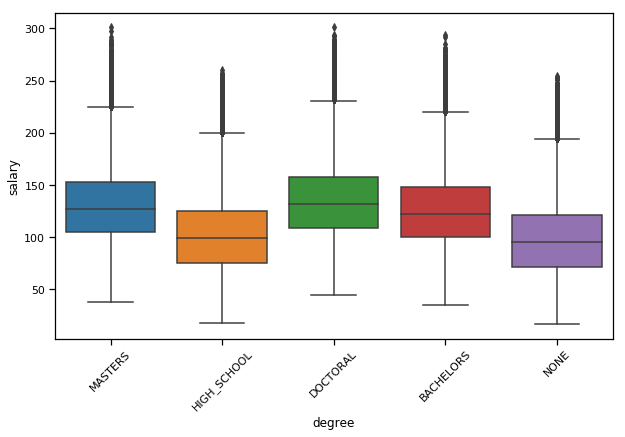

In [41]:
# View relationship between salary and degree
var = 'degree'
data = pd.concat([train_data_merged['salary'], train_data_merged[var]], axis=1)
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.boxplot(x=var, y='salary', data=data)
plt.xticks(rotation=45)


# Having a college degree vs no college degree seems to have a correlation with salary
# Graduate degrees have higher range than undergrad

In [42]:
# Get counts for each degree and convert to dataframe

degree_counts =  train_data_merged['degree'].value_counts().to_frame()
print(degree_counts)

# Each college degree has similar number of employess, No degree & high school higher

# Rename column and index in degree_counts
degree_counts.rename(columns={'degree': 'value_counts'}, inplace=True)
degree_counts.index.name = 'degree'
degree_counts

             degree
HIGH_SCHOOL  236975
NONE         236853
BACHELORS    175495
DOCTORAL     175362
MASTERS      175310


,value_counts
degree,
HIGH_SCHOOL,236975
NONE,236853
BACHELORS,175495
DOCTORAL,175362
MASTERS,175310


In [43]:
# Group degree_counts, find mean salary of each degree
degreeGrouped = train_data_merged[['degree', 'salary']]
degreeGrouped = degreeGrouped.groupby(['degree'], as_index=False).mean()
degreeGrouped

# Graduate degrees have higher average salary than undergraduate

,degree,salary
0,BACHELORS,125.454663
1,DOCTORAL,135.490979
2,HIGH_SCHOOL,101.921085
3,MASTERS,130.505647
4,NONE,98.176882


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

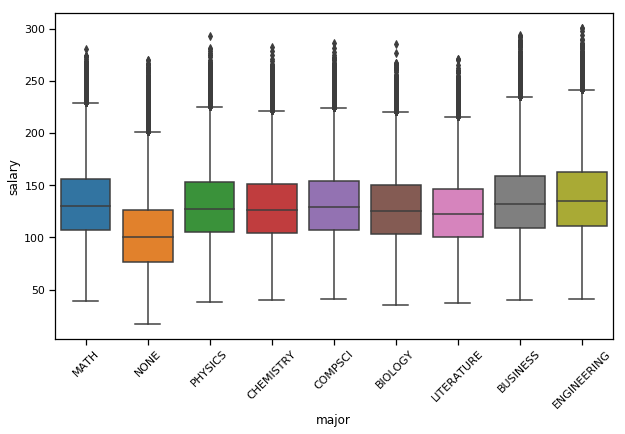

In [44]:
# View relationship between salary and major
var = 'major'
data = pd.concat([train_data_merged['salary'], train_data_merged[var]], axis=1)
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.boxplot(x=var, y='salary', data=data)
plt.xticks(rotation=45)


# Having no major correlated with lower salary than having a major

In [45]:
# Value counts for each major and convert to dataframe

major_counts =  train_data_merged['major'].value_counts().to_frame()
print(major_counts)

# Each major (except "None") has similar amount
# Are most of "None" majors from no degree or high school only?

# Rename column and index in major_counts
major_counts.rename(columns={'major': 'value_counts'}, inplace=True)
major_counts.index.name = 'major'
major_counts

              major
NONE         532353
CHEMISTRY     58875
LITERATURE    58684
ENGINEERING   58594
BUSINESS      58518
PHYSICS       58410
COMPSCI       58382
BIOLOGY       58379
MATH          57800


,value_counts
major,
NONE,532353
CHEMISTRY,58875
LITERATURE,58684
ENGINEERING,58594
BUSINESS,58518
PHYSICS,58410
COMPSCI,58382
BIOLOGY,58379
MATH,57800


In [46]:
# Group major_counts, find mean salary of each major
majorGrouped = train_data_merged[['major', 'salary']]
majorGrouped = majorGrouped.groupby(['major'], as_index=False).mean()
majorGrouped

# Engineering degrees have highest average salary, followed by business. Having no major has the lowest average salary

,major,salary
0,BIOLOGY,127.932664
1,BUSINESS,135.648980
2,CHEMISTRY,129.072085
3,COMPSCI,132.075605
4,ENGINEERING,138.441342
5,LITERATURE,124.423097
6,MATH,133.322042
7,NONE,102.583864
8,PHYSICS,130.372436


(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

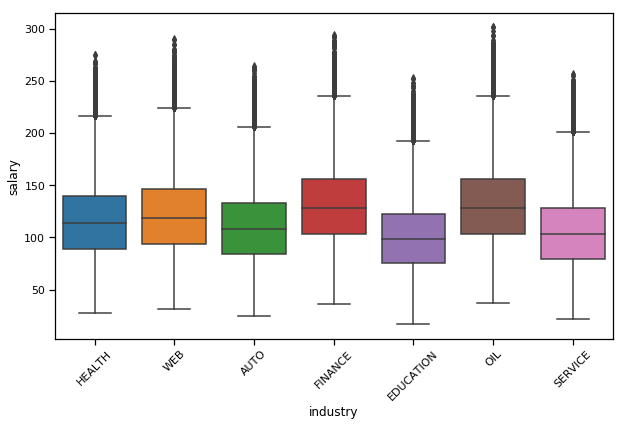

In [47]:
# View relationship between salary and industry
var = 'industry'
data = pd.concat([train_data_merged['salary'], train_data_merged[var]], axis=1)
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.boxplot(x=var, y='salary', data=data)
plt.xticks(rotation=45)


# Education and service industries seem to have lowest salaries, followed by auto in dustry

In [48]:
# Value counts for each industry and convert to dataframe

industry_counts =  train_data_merged['industry'].value_counts().to_frame()
print(industry_counts)

# Each industry has similar amount

# Rename column and index in industry_counts
industry_counts.rename(columns={'industry': 'value_counts'}, inplace=True)
industry_counts.index.name = 'industry'
industry_counts

           industry
WEB          143205
AUTO         142941
FINANCE      142866
EDUCATION    142819
OIL          142770
HEALTH       142755
SERVICE      142639


,value_counts
industry,
WEB,143205
AUTO,142941
FINANCE,142866
EDUCATION,142819
OIL,142770
HEALTH,142755
SERVICE,142639


In [49]:
# Group industry_counts, find mean salary of each industry
industryGrouped = train_data_merged[['industry', 'salary']]
industryGrouped = industryGrouped.groupby(['industry'], as_index=True).mean()
industryGrouped

# Average salaries are as expected from boxplot, with oil industry having the highest (closely followed by finance)

,salary
industry,
AUTO,109.435222
EDUCATION,99.448386
FINANCE,130.747659
HEALTH,115.735540
OIL,130.953863
SERVICE,104.446820
WEB,121.645362


In [50]:
# Create one large table with mean salaries of categorical data
merged_Grouped_cols = train_data_merged[['companyId', 'jobType', 'degree', 'major', 'industry',
       'yearsExperience', 'milesFromMetropolis', 'salary']]

grouped_vars_meanSalary = merged_Grouped_cols.groupby(['companyId', 'jobType', 'degree', 'major', 'industry',
       'yearsExperience', 'milesFromMetropolis']).mean()

grouped_vars_meanSalary

salary
companyId jobType        degree    major   industry  yearsExperience milesFromMetropolis        
COMP0     CEO            BACHELORS BIOLOGY AUTO      6               28                    118.0
                                                     9               42                    115.0
                                                     14              57                    163.0
                                                                     95                    115.0
                                                     16              3                     183.0
                                                     21              36                    165.0
                                           EDUCATION 7               60                    140.0
                                                     20              91                    100.0
                                                     23              72                    151.0
                                           FINANCE   2               32                    136.0
                                                     3               16                    165.0
                                                     5               64                    170.0
                                                     10              33                    139.0
                                                     12              10                    212.0
                                                     22              61                    155.0
                                                     23              49                    136.0
                                           HEALTH    0               39                    102.0
                                                     5               34                    154.0
                                                     6               84                    118.0
                                                     8               21                    150.0
                                                     16              69                    116.0
                                                     17              22                    144.0
                                                     19              48                    185.0
                                                     20              62                    139.0
                                                     23              64                    192.0
                                           OIL       6               36                    170.0
                                                     9               98                    101.0
                                                     19              70                    150.0
                                                     23              78                    200.0
                                           SERVICE   4               97                    121.0
...                                                                                          ...
COMP9     VICE_PRESIDENT NONE      NONE    WEB       12              40                    110.0
                                                                     54                    137.0
                                                                     67                     89.0
                                                     13              33                    148.0
                                                                     54                    136.0
                                                                     80                     94.0
                                                     14              93                    121.0
                                                     15              21                    114.0
                                                                     93                     90.0
                

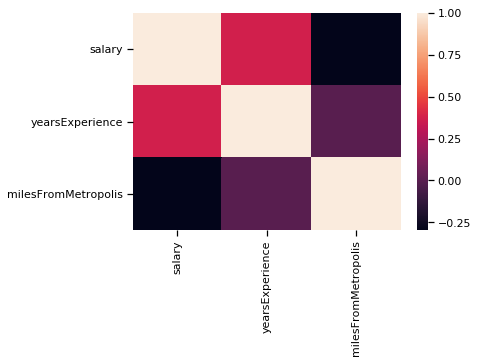

In [89]:
sns.heatmap(train_data_merged.corr())

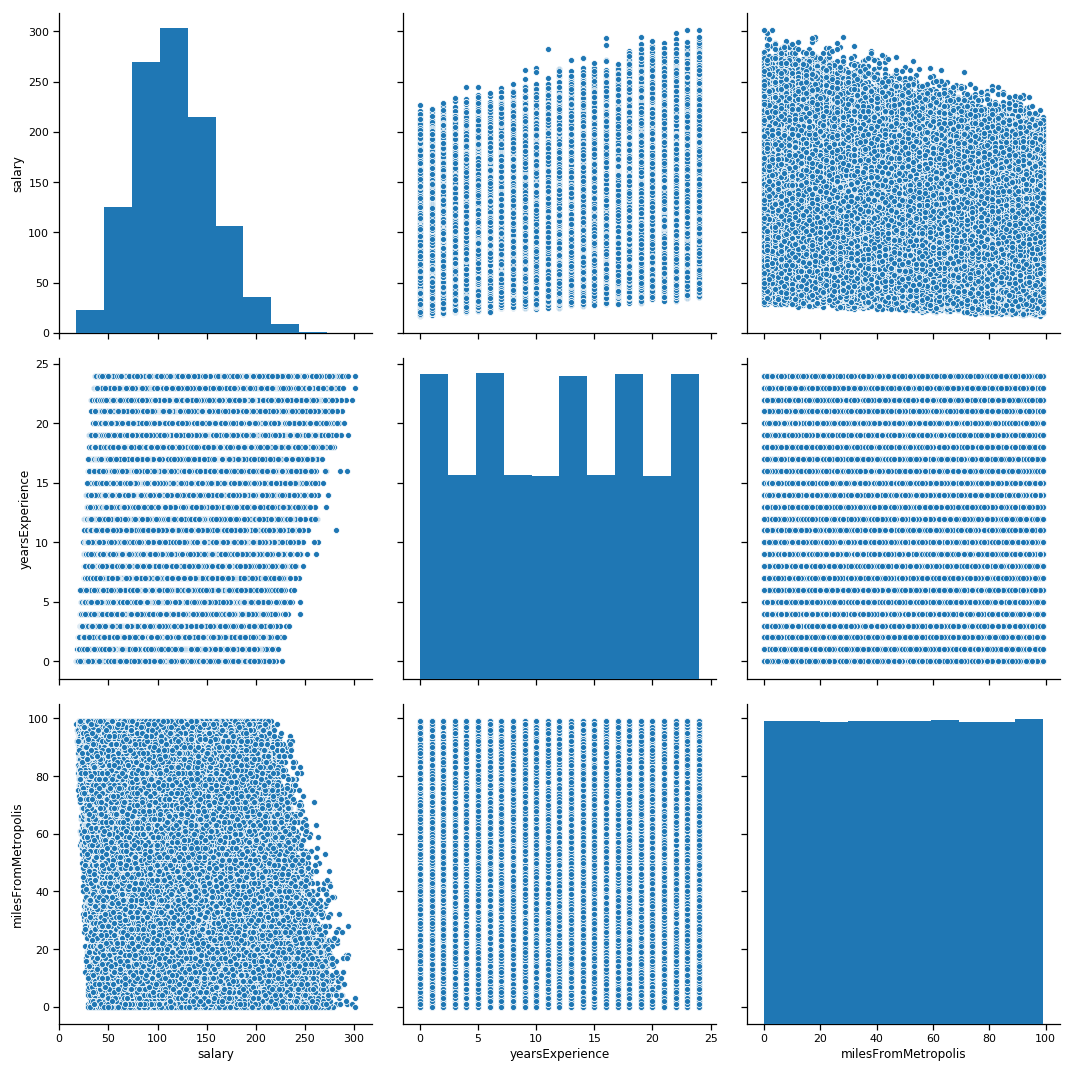

In [69]:
cols = ['salary','yearsExperience', 'milesFromMetropolis']

sns.pairplot(train_data_merged[cols], height=5)

In [70]:
# Check for outliers
salary_scaled = StandardScaler().fit_transform(train_data_merged['salary'][:,np.newaxis]);
low_range = salary_scaled[salary_scaled[:,0].argsort()][:10]
high_range= salary_scaled[salary_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

# No single datapoint too far out of range

/Users/DJ/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/DJ/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


outer range (low) of the distribution:
[[-2.55861843]
 [-2.53279008]
 [-2.53279008]
 [-2.53279008]
 [-2.50696173]
 [-2.50696173]
 [-2.50696173]
 [-2.50696173]
 [-2.50696173]
 [-2.50696173]]

outer range (high) of the distribution:
[[4.49252149]
 [4.5441782 ]
 [4.5441782 ]
 [4.57000655]
 [4.57000655]
 [4.5958349 ]
 [4.5958349 ]
 [4.6991483 ]
 [4.77663336]
 [4.77663336]]


### ---- 5 Establish a baseline ----

In [ ]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation

### ---- 6 Hypothesize solution ----

In [ ]:
#brainstorm 3 models that you think may improve results over the baseline model based
#on your 

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

In [ ]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

### ---- 8 Create models ----

In [ ]:
#create and tune the models that you brainstormed during part 2

### ---- 9 Test models ----

In [ ]:
#do 5-fold cross validation on models and measure MSE

### ---- 10 Select best model  ----

In [ ]:
#select the model with the lowest error as your "prodcuction" model

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [ ]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [ ]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data